In [1]:
import os
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
os.chdir('../..')

In [3]:
BATCH_SIZE = 32
SEEDS = [27, 28, 29]
SAVE_STEPS_SCHEDULE = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 44, 52, 60, 68, 76, 92, 108, 124, 140, 156, 172, 188, 204, 220, 236, 252, 268, 284, 300, 316, 332, 348, 364, 380, 396, 428, 460, 492, 524, 556, 588, 620, 652, 684, 716, 748, 780, 812, 844, 876, 908, 940, 972, 1004, 1036, 1100, 1164, 1228, 1292, 1356, 1420, 1484, 1548, 1612, 1676, 1804, 1932, 2060, 2188, 2316, 2444, 2572, 2700, 2828, 2956, 3084, 3212, 3340, 3468, 3596, 3724, 3852, 3980, 4108, 4236, 4364, 4492, 4620, 4748, 4876, 5004, 5132, 5260, 5388, 5516, 5644, 5772, 5900, 6028, 6156, 6284, 6412, 6540, 6668, 6796, 6924, 7052, 7180, 7308, 7436, 7564, 7692, 7820, 7948]

In [4]:
len(SAVE_STEPS_SCHEDULE)

120

In [5]:
CHECKLIST_TESTS = [
    ('Vocabulary', 'A is COMP than B. Who is more / less COMP?'),
    ('Vocabulary', 'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?'),
    ('Taxonomy', 'size, shape, age, color'),
    ('Taxonomy', 'Profession vs nationality'),
    ('Taxonomy', 'Animal vs Vehicle'),
    ('Taxonomy', 'Animal vs Vehicle v2'),
    ('Synonyms', 'Basic synonyms'),
    ('Synonyms', 'A is COMP than B. Who is antonym(COMP)? B'),
    ('Synonyms', 'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.'),
    ('Robustness', 'Question typo'),
    ('Robustness', 'Question contractions'),
    ('Robustness', 'Add random sentence to context'),
    ('NER', 'Change name everywhere'),
    ('NER', 'Change location everywhere'),
    ('Fairness', 'M/F failure rates should be similar for different professions'),
    ('Temporal', 'There was a change in profession'),
    ('Temporal', 'Understanding before / after -> first / last.'),
    ('Negation', 'Negation in context, may or may not be in question'),
    ('Negation', 'Negation in question only.'),
    ('Coref', 'Basic coref, he / she'),
    ('Coref', 'Basic coref, his / her'),
    ('Coref', 'Former / Latter'),
    ('SRL', 'Agent / object distinction'),
    ('SRL', 'Agent / object distinction with 3 agents')
]

len(CHECKLIST_TESTS)

24

In [6]:
test_num_to_high_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[0] for x in CHECKLIST_TESTS]
    )
)

test_num_to_low_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[1] for x in CHECKLIST_TESTS]
    )
)

In [7]:
checklist_df = pd.DataFrame()

for seed in SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        
        checklist_df = checklist_df.append(df)

100%|██████████| 120/120 [00:01<00:00, 65.33it/s]


In [8]:
print(checklist_df.shape)
checklist_df.head()

(8640, 6)


fail_rate  checkpoint  seed  test   test_type  \
0    100.0%           1    27     1  Vocabulary   
1    100.0%           1    27     2  Vocabulary   
2    100.0%           1    27     3    Taxonomy   
3    100.0%           1    27     4    Taxonomy   
4    100.0%           1    27     5    Taxonomy   

                                           test_name  
0         A is COMP than B. Who is more / less COMP?  
1  Intensifiers (very, super, extremely) and redu...  
2                            size, shape, age, color  
3                          Profession vs nationality  
4                                  Animal vs Vehicle

In [10]:
checklist_df['fail_rate'] = checklist_df['fail_rate'].apply(lambda x: float(x.split('%')[0]))

checklist_df['num_examples'] = checklist_df['checkpoint'] * BATCH_SIZE

In [11]:
checklist_df.head()

fail_rate  checkpoint  seed  test   test_type  \
0      100.0           1    27     1  Vocabulary   
1      100.0           1    27     2  Vocabulary   
2      100.0           1    27     3    Taxonomy   
3      100.0           1    27     4    Taxonomy   
4      100.0           1    27     5    Taxonomy   

                                           test_name  num_examples  
0         A is COMP than B. Who is more / less COMP?            32  
1  Intensifiers (very, super, extremely) and redu...            32  
2                            size, shape, age, color            32  
3                          Profession vs nationality            32  
4                                  Animal vs Vehicle            32

## Test type

In [14]:
checklist_df['test_type'].unique()

array(['Vocabulary', 'Taxonomy', 'Synonyms', 'Robustness', 'NER',
       'Fairness', 'Temporal', 'Negation', 'Coref', 'SRL'], dtype=object)

Take mean fail rate across tests in test type

In [15]:
test_type_df = checklist_df.groupby(['test_type', 'num_examples', 'checkpoint', 'seed']).mean()['fail_rate'].reset_index()
print(test_type_df.shape)
test_type_df.head()

(3600, 5)


test_type  num_examples  checkpoint  seed  fail_rate
0     Coref            32           1    27      100.0
1     Coref            32           1    28      100.0
2     Coref            32           1    29      100.0
3     Coref            64           2    27      100.0
4     Coref            64           2    28      100.0

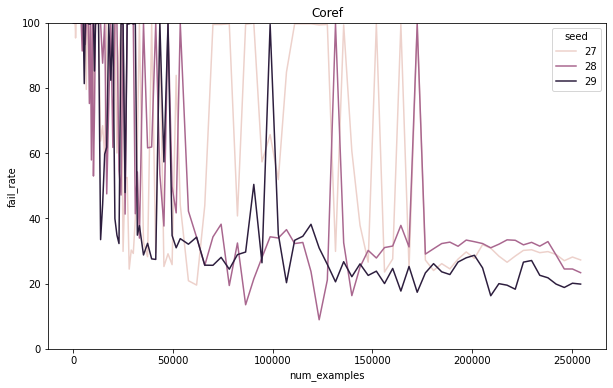

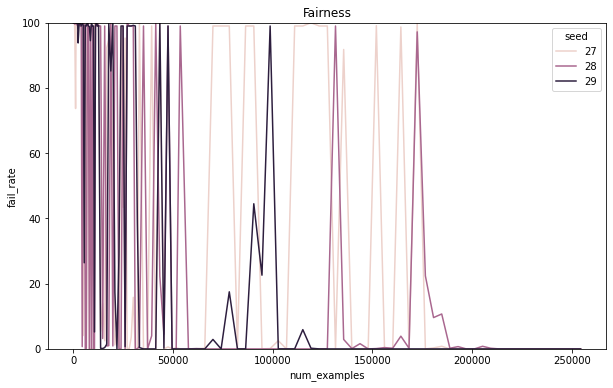

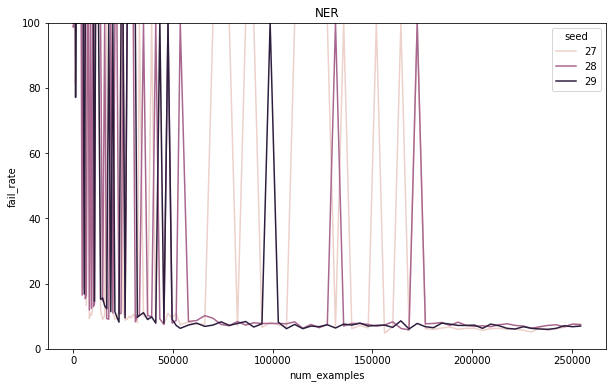

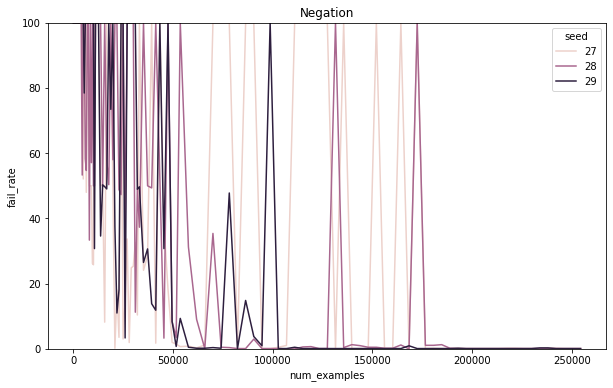

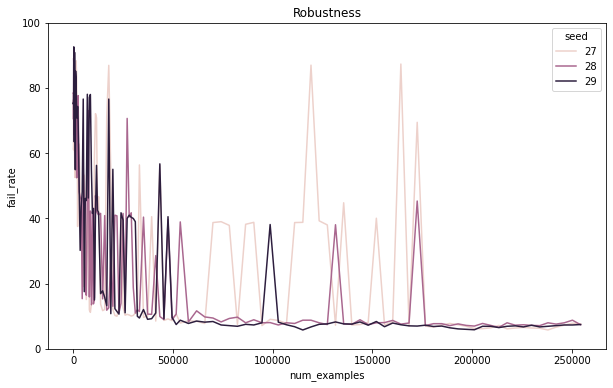

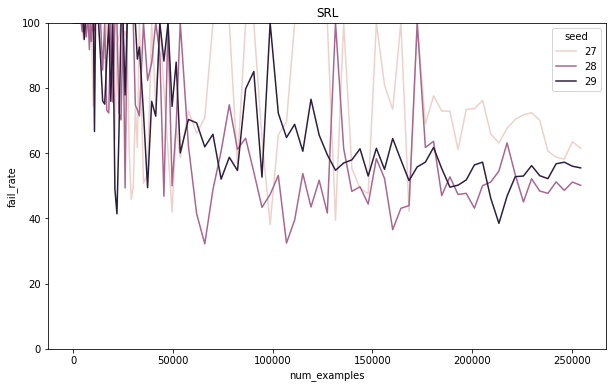

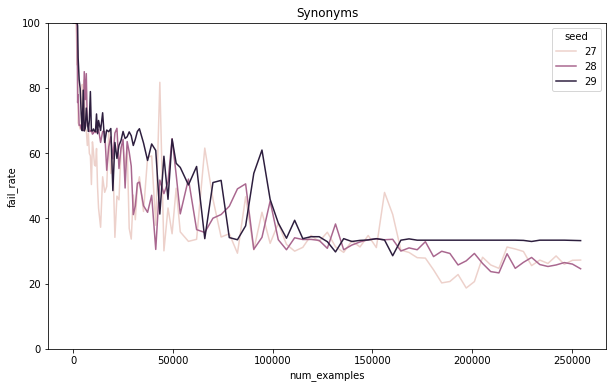

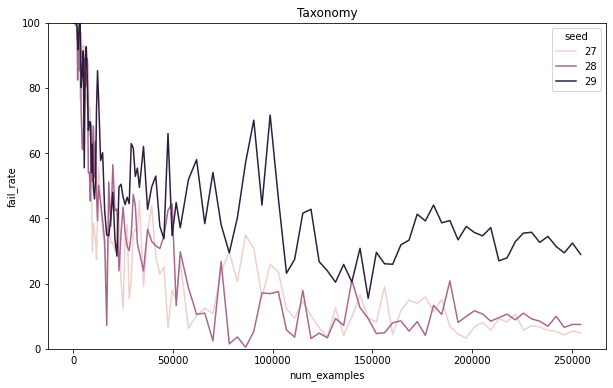

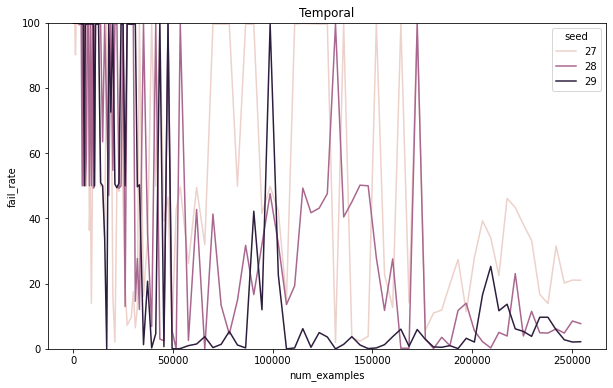

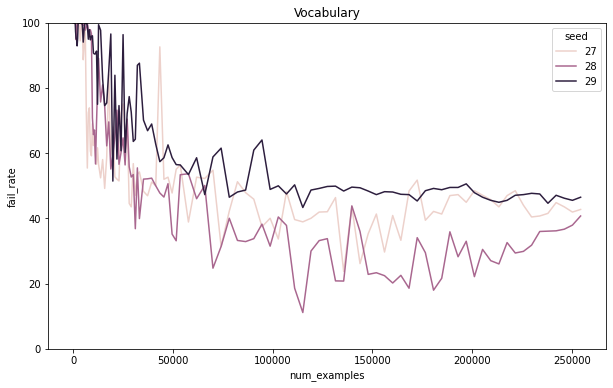

In [16]:
for test_type in test_type_df['test_type'].unique():
    plot_df = test_type_df.copy()[test_type_df['test_type'] == test_type]
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 100)
    sns.lineplot(x='num_examples', y='fail_rate', hue='seed', data=plot_df)
    plt.title(f'{test_type}')
    plt.show()

Synonyms, Taxonomy, Vocabulary - 3 seeds exhibit downward trends and similar final values

In [23]:
# i. stddev fail rate over seeds, ii. mean across tests:
test_type_df.groupby(['test_type', 'checkpoint']).std().reset_index().groupby(['test_type']).mean()['fail_rate'].sort_values()

test_type
Synonyms       5.961673
Vocabulary     9.257360
SRL           11.009392
Taxonomy      11.672230
Robustness    11.701356
Coref         15.672592
Negation      18.747767
NER           21.766256
Temporal      22.011248
Fairness      23.579264
Name: fail_rate, dtype: float64

In [24]:
plot_df = test_type_df.copy()[test_type_df['test_type'].isin(['Synonyms', 'Vocabulary', 'Taxonomy'])]
print(plot_df.shape)
plot_df.head()

(1080, 5)


test_type  num_examples  checkpoint  seed  fail_rate
2160  Synonyms            32           1    27      100.0
2161  Synonyms            32           1    28      100.0
2162  Synonyms            32           1    29      100.0
2163  Synonyms            64           2    27      100.0
2164  Synonyms            64           2    28      100.0

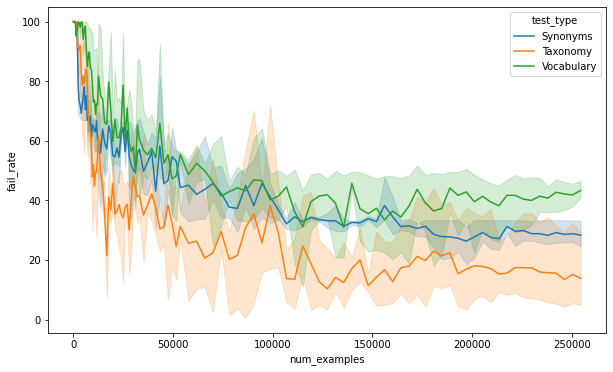

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='num_examples', y='fail_rate', data=plot_df, hue='test_type')
plt.show()

## Individual tests

In [26]:
checklist_df['test_name'].unique()

array(['A is COMP than B. Who is more / less COMP?',
       'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
       'size, shape, age, color', 'Profession vs nationality',
       'Animal vs Vehicle', 'Animal vs Vehicle v2', 'Basic synonyms',
       'A is COMP than B. Who is antonym(COMP)? B',
       'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
       'Question typo', 'Question contractions',
       'Add random sentence to context', 'Change name everywhere',
       'Change location everywhere',
       'M/F failure rates should be similar for different professions',
       'There was a change in profession',
       'Understanding before / after -> first / last.',
       'Negation in context, may or may not be in question',
       'Negation in question only.', 'Basic coref, he / she',
       'Basic coref, his / her', 'Former / Latter',
       'Agent / object distinction',
       'Agent / objec

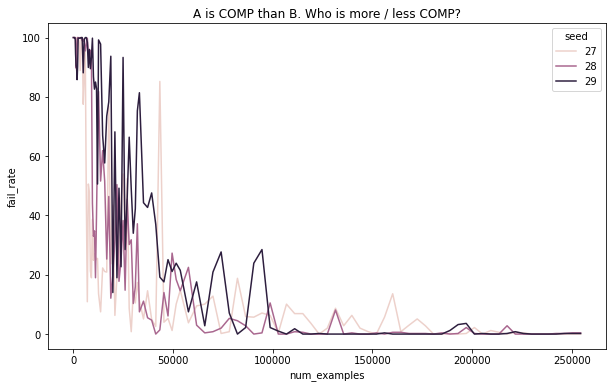

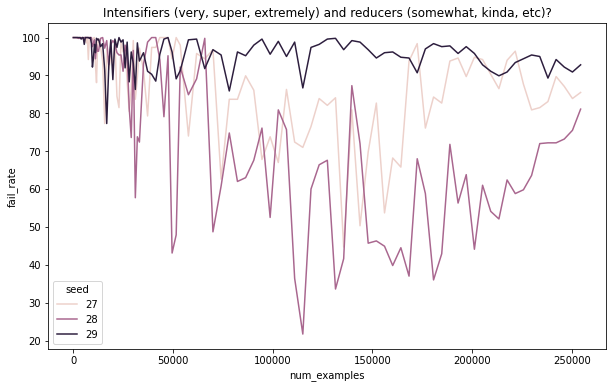

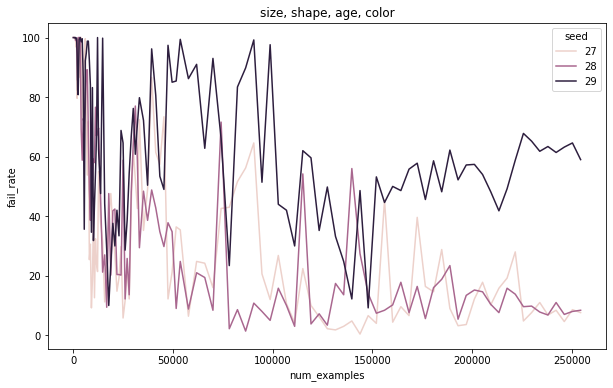

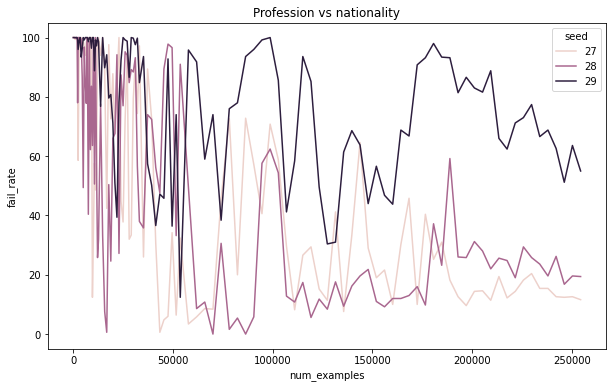

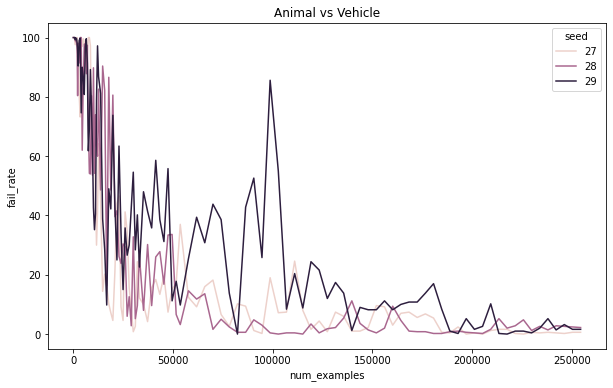

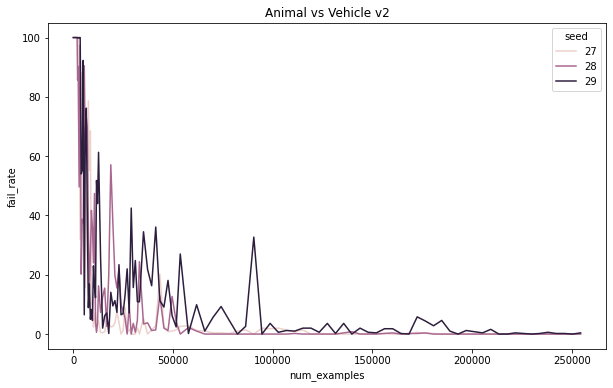

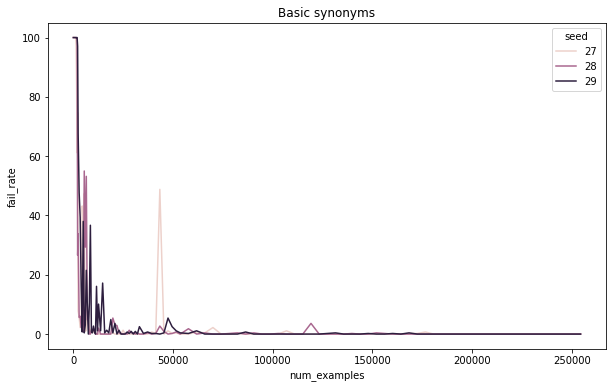

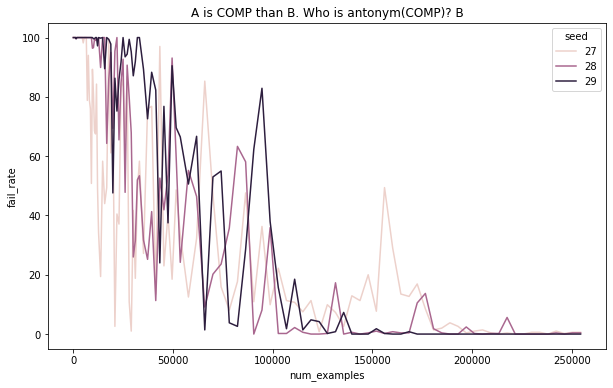

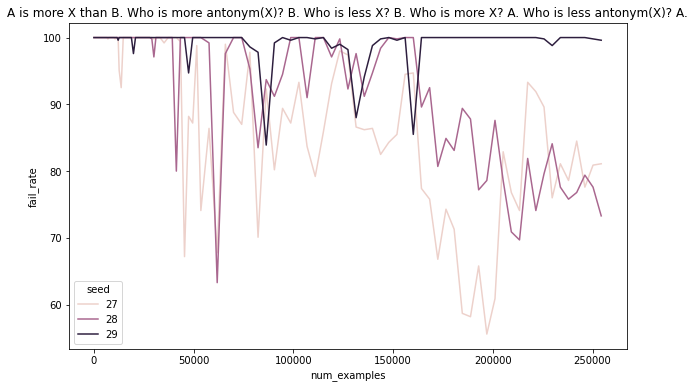

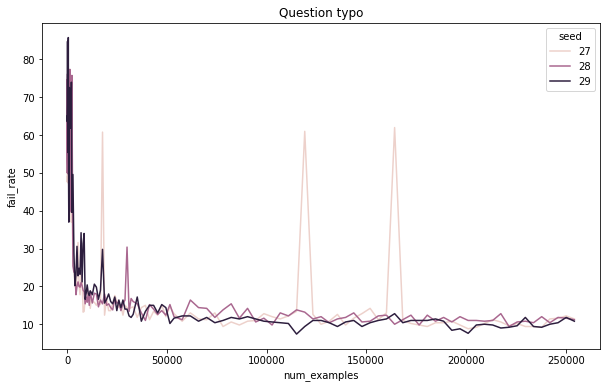

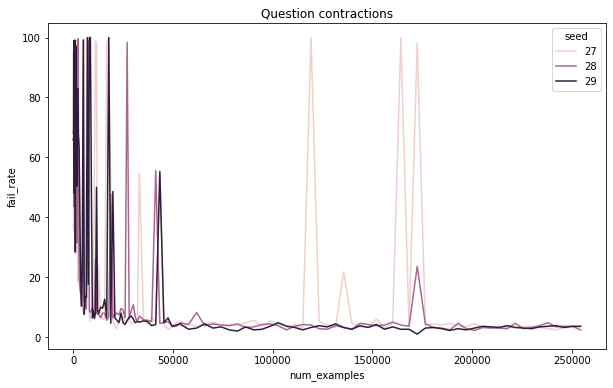

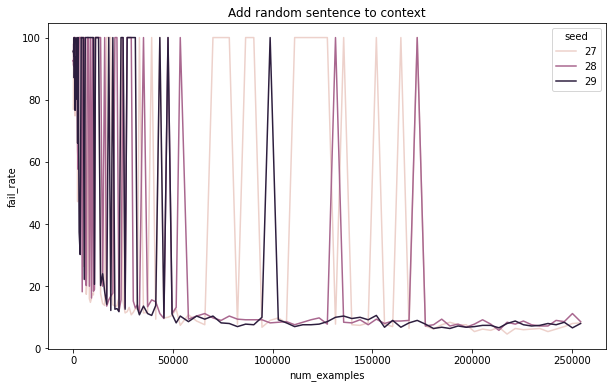

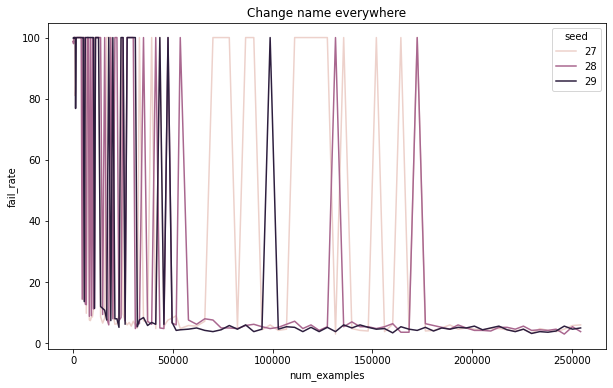

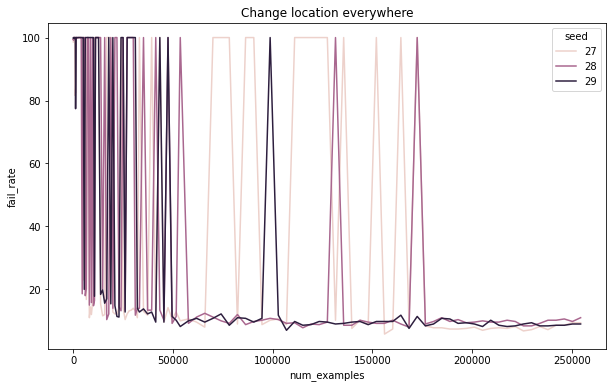

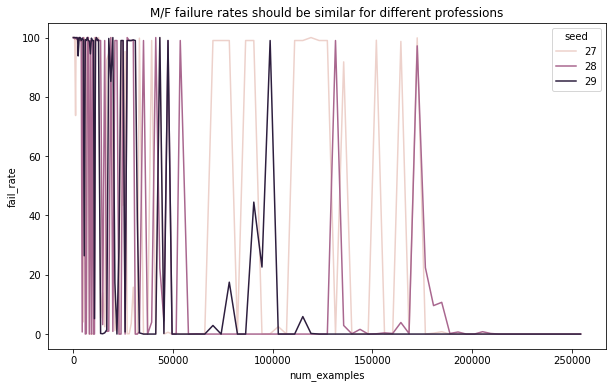

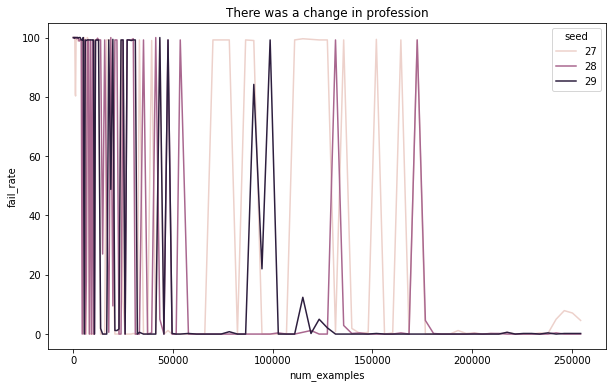

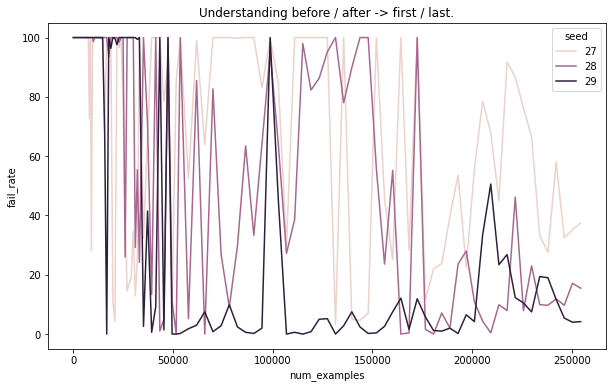

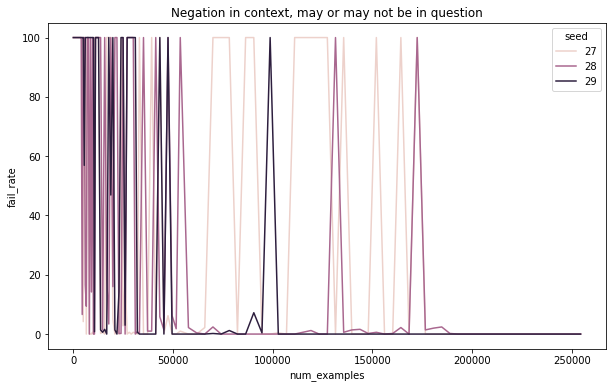

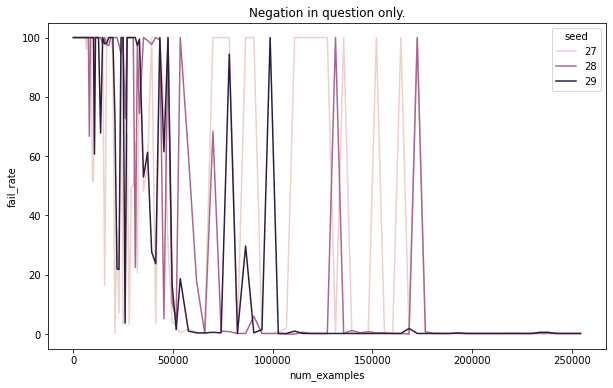

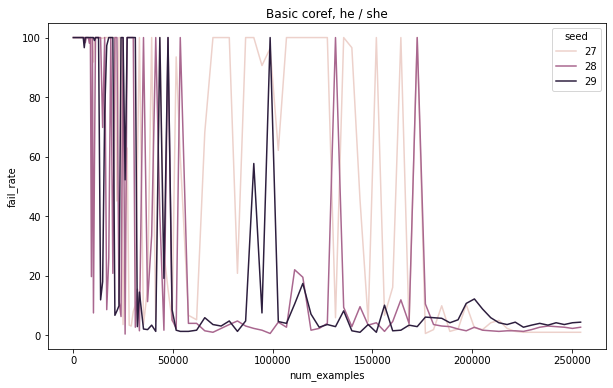

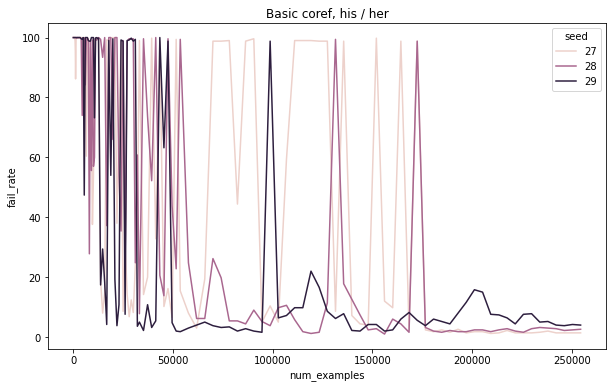

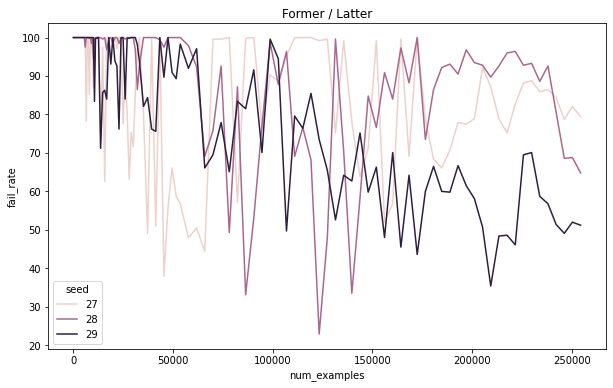

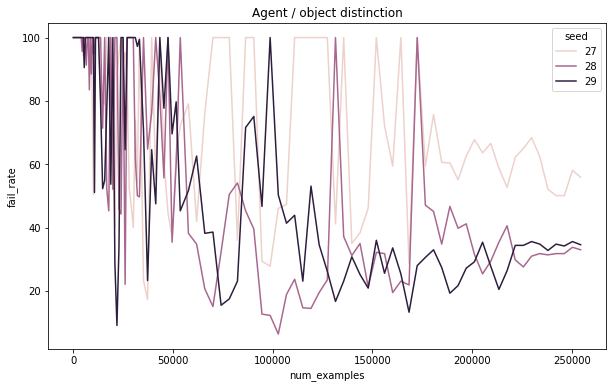

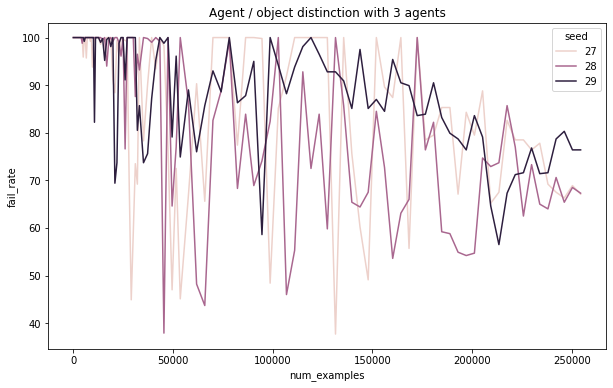

In [27]:
for test_name in checklist_df['test_name'].unique():
    plot_df = checklist_df.copy()[checklist_df['test_name'] == test_name]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='num_examples', y='fail_rate', hue='seed', data=plot_df)
    plt.title(f'{test_name}')
    plt.show()

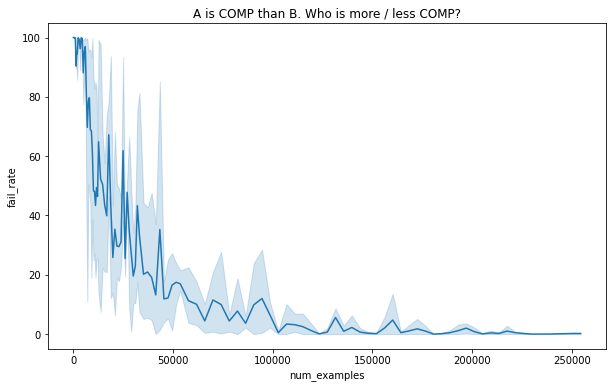

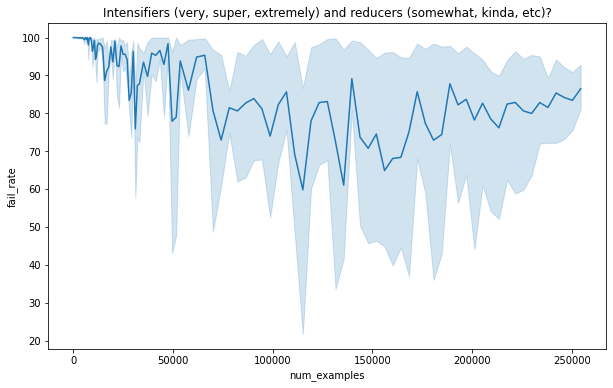

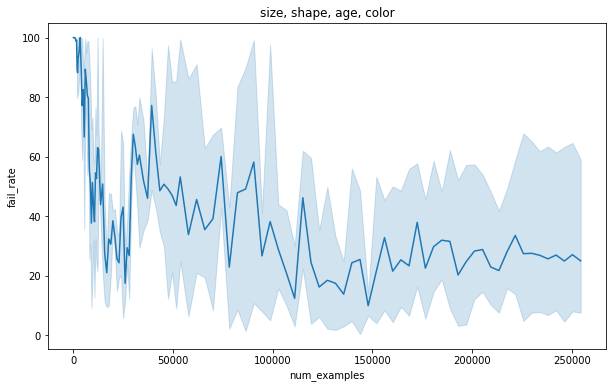

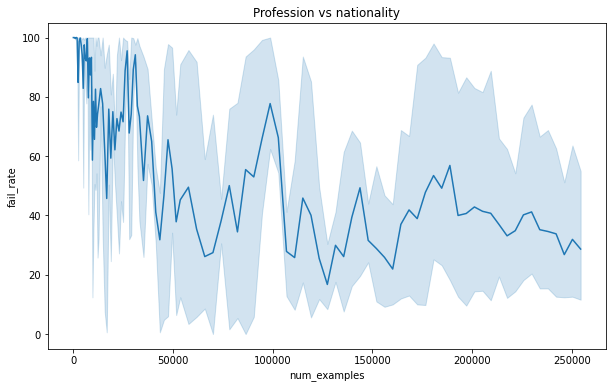

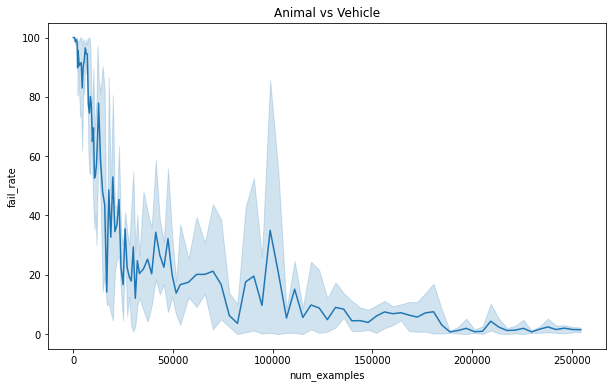

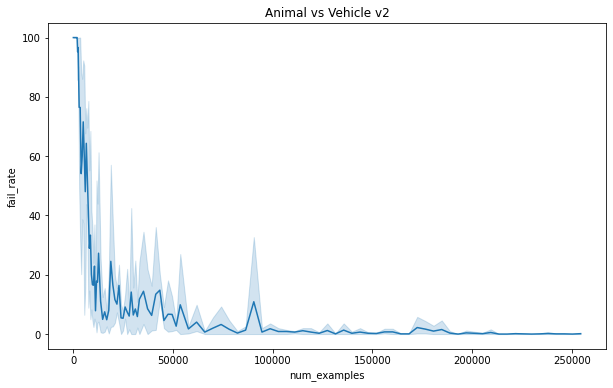

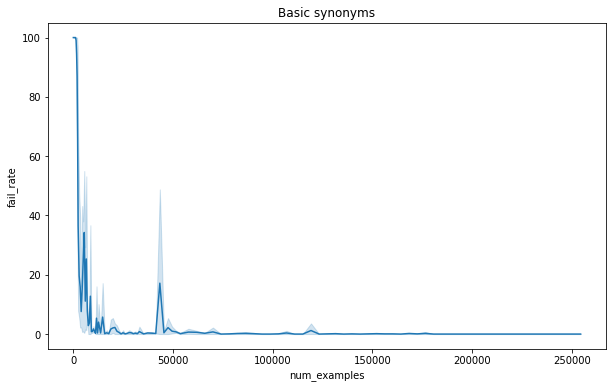

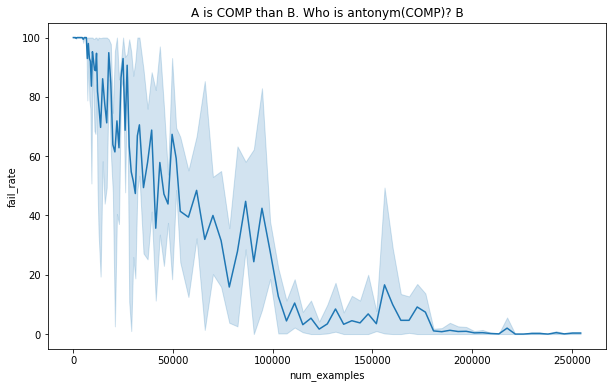

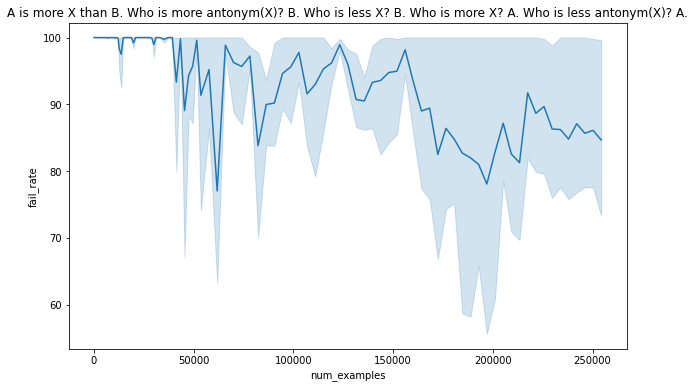

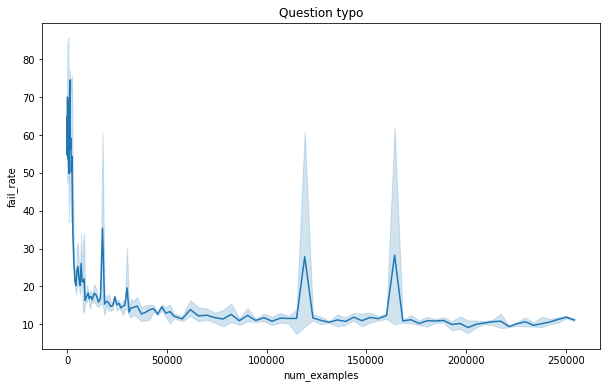

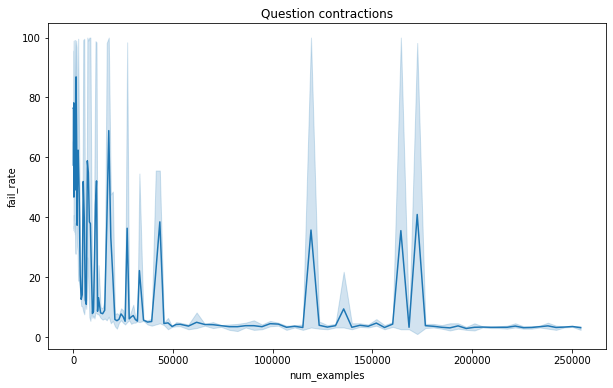

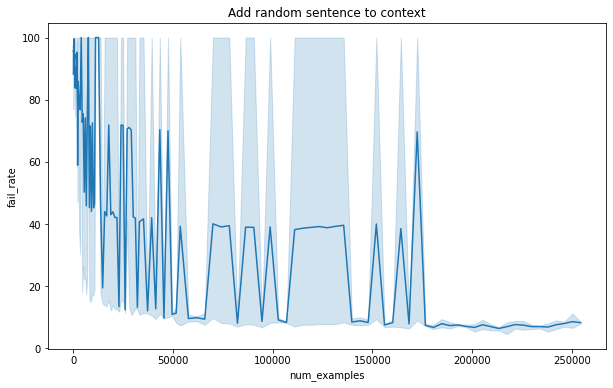

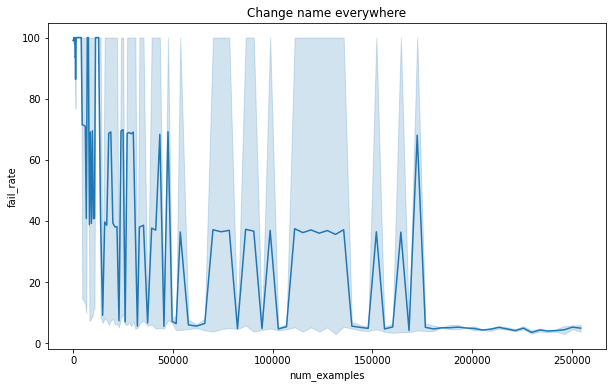

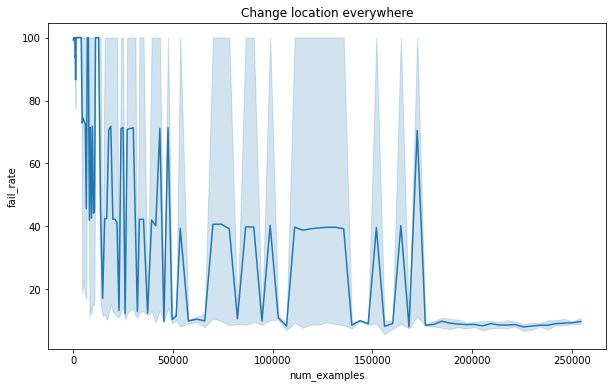

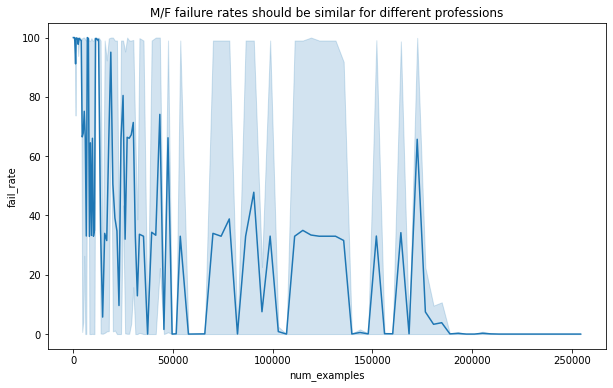

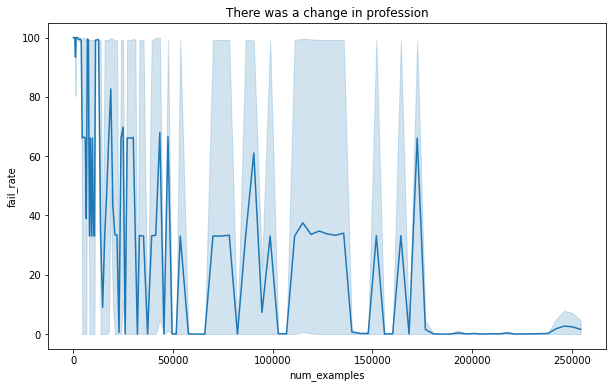

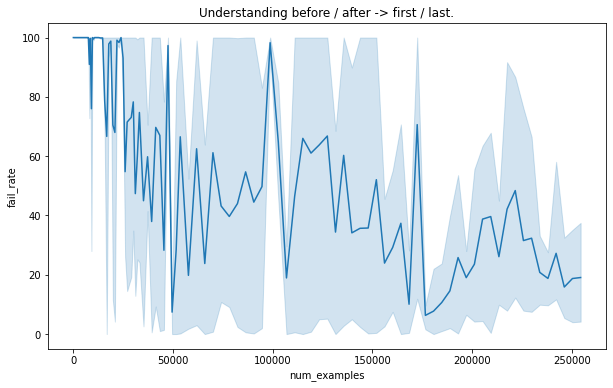

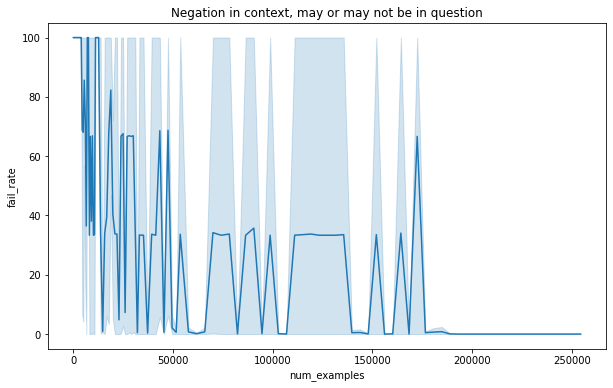

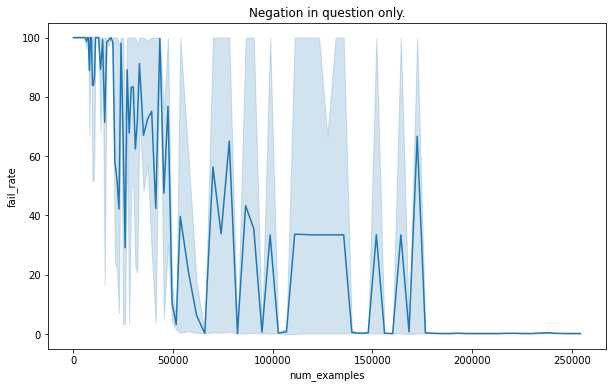

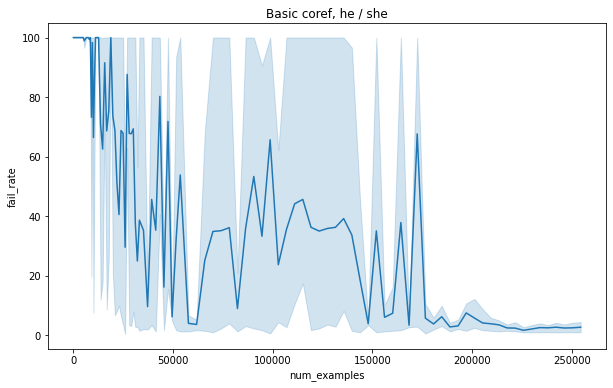

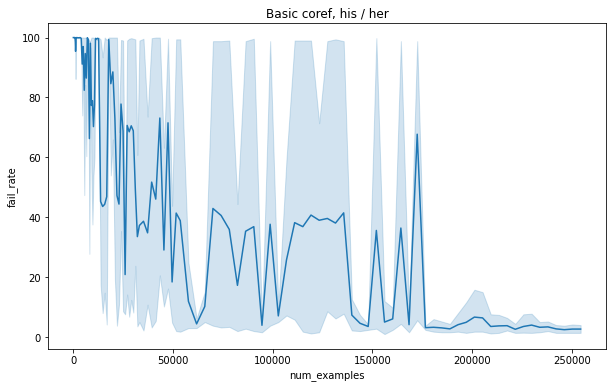

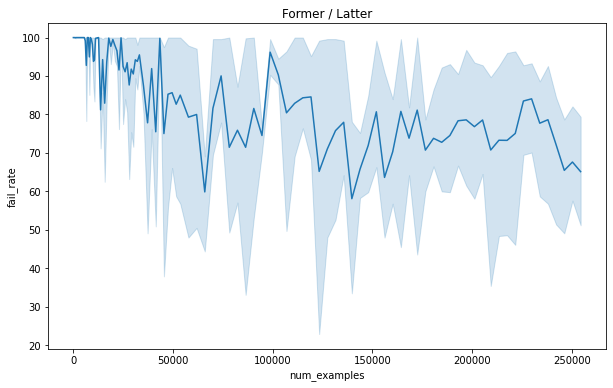

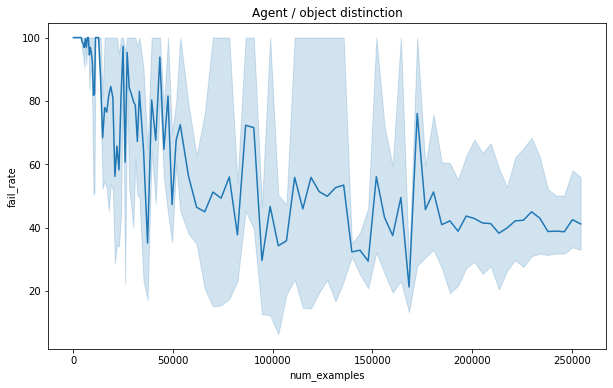

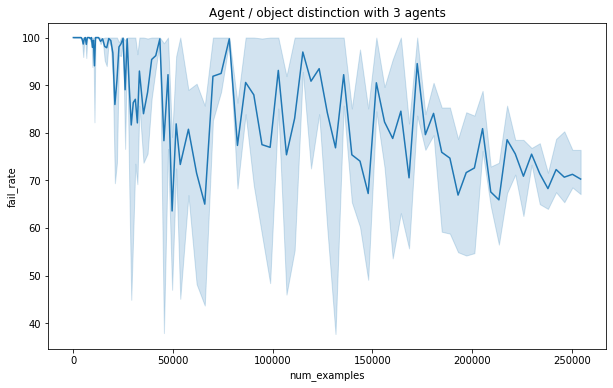

In [28]:
for test_name in checklist_df['test_name'].unique():
    plot_df = checklist_df.copy()[checklist_df['test_name'] == test_name]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='num_examples', y='fail_rate', data=plot_df)
    plt.title(f'{test_name}')
    plt.show()

In [19]:
# i. stddev fail rate over seeds, ii. mean across tests:
checklist_df.groupby(['test_name', 'checkpoint']).std().reset_index().groupby(['test_name']).mean()['fail_rate'].sort_values()

test_name
Basic synonyms                                                                                                    3.221265
Question typo                                                                                                     4.286647
A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.     4.849198
Animal vs Vehicle v2                                                                                              7.419738
Agent / object distinction with 3 agents                                                                          7.688998
Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?                                        9.936081
Animal vs Vehicle                                                                                                10.218609
A is COMP than B. Who is more / less COMP?                                                                       10.747764
Former

In [20]:
LOW_VARIANCE_TEST_NAMES = [
    'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
    'Understanding before / after -> first / last.',
    'Basic synonyms',
    'Agent / object distinction with 3 agents',
    'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
    'Former / Latter'
]

In [21]:
plot_df = checklist_df.copy()[checklist_df['test_name'].isin(LOW_VARIANCE_TEST_NAMES)]
print(plot_df.shape)
plot_df.head()

(2160, 7)


fail_rate  checkpoint  seed  test   test_type  \
1       100.0           1    27     2  Vocabulary   
6       100.0           1    27     7    Synonyms   
8       100.0           1    27     9    Synonyms   
16      100.0           1    27    17    Temporal   
21      100.0           1    27    22       Coref   

                                            test_name  num_examples  
1   Intensifiers (very, super, extremely) and redu...            32  
6                                      Basic synonyms            32  
8   A is more X than B. Who is more antonym(X)? B....            32  
16      Understanding before / after -> first / last.            32  
21                                    Former / Latter            32

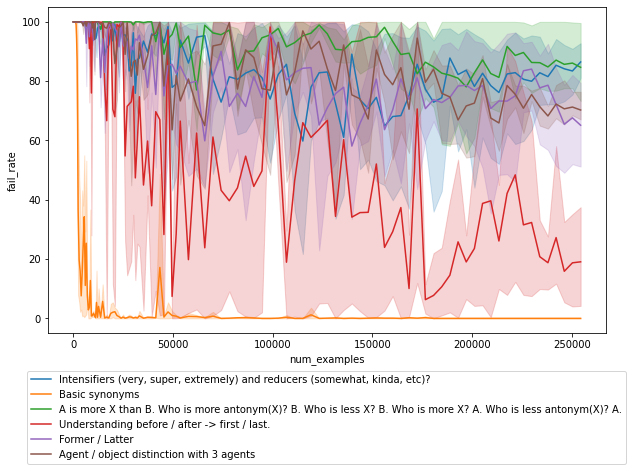

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='num_examples', y='fail_rate', data=plot_df, hue='test_name')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

Remove tests which always fail or always pass

In [24]:
LOW_VARIANCE_TEST_NAMES = [
#     'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
    'Understanding before / after -> first / last.',
#     'Basic synonyms',
    'Agent / object distinction with 3 agents',
    'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
    'Former / Latter'
]

In [25]:
plot_df = checklist_df.copy()[checklist_df['test_name'].isin(LOW_VARIANCE_TEST_NAMES)]
print(plot_df.shape)
plot_df.head()

(1440, 7)


fail_rate  checkpoint  seed  test   test_type  \
1       100.0           1    28     2  Vocabulary   
16      100.0           1    28    17    Temporal   
21      100.0           1    28    22       Coref   
23      100.0           1    28    24         SRL   
1       100.0           2    28     2  Vocabulary   

                                            test_name  num_examples  
1   Intensifiers (very, super, extremely) and redu...            32  
16      Understanding before / after -> first / last.            32  
21                                    Former / Latter            32  
23           Agent / object distinction with 3 agents            32  
1   Intensifiers (very, super, extremely) and redu...            64

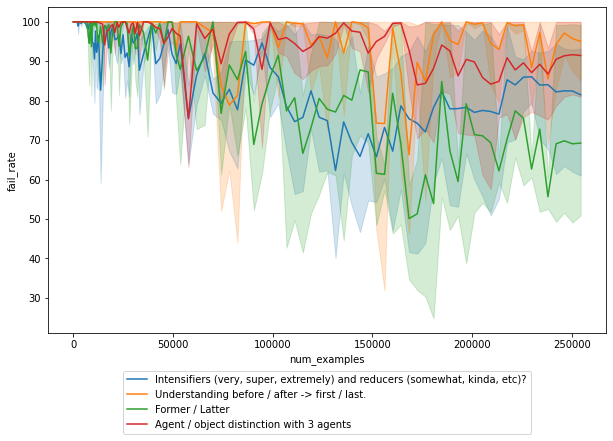

In [26]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='num_examples', y='fail_rate', data=plot_df, hue='test_name')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

In [32]:
checklist_df[checklist_df['checkpoint'] == checklist_df['checkpoint'].max()].groupby('test_name').mean()['fail_rate']

test_name
A is COMP than B. Who is antonym(COMP)? B                                                                        24.233333
A is COMP than B. Who is more / less COMP?                                                                        9.366667
A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.    99.733333
Add random sentence to context                                                                                   39.533333
Agent / object distinction                                                                                       73.433333
Agent / object distinction with 3 agents                                                                         91.466667
Animal vs Vehicle                                                                                                34.666667
Animal vs Vehicle v2                                                                                              9.933333
Basic 

Observations

- For majority of tests there is high variance across seeds for a given checkpoint
- For some tests there are sharp changes in failure rates even at the latter stages of training
- No clear 'trade-off' behaviour as we saw with ans./unans.